In [1]:
from copy import deepcopy
import datetime
import gc
import os
import pathlib
import random
import sys
sys.path.append('..')
from typing import Any, Dict, List, Tuple, Union

from joblib import dump
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import OrdinalEncoder
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from scripts.evaluate import Evaluator
from scripts.get_depth_paths import get_depth_paths
from scripts.get_logger import get_logger
from scripts.merge_dataset import merge_dataset

gc.enable()

/home/ss/miniconda3/envs/home_credit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PathHandler:
    competition_dir = pathlib.Path('../../inputs')
    parquet_files_dir = competition_dir.joinpath('parquet_files')
    feature_dir = pathlib.Path('../../outputs/features')
    now_time = datetime.datetime.now()
    output_dir = pathlib.Path(
        '../../outputs/output_dae/'
        + f'model_outputs_{now_time.date()}-{now_time.hour:02}-{now_time.minute:02}'
    )
    if not output_dir.is_dir():
        output_dir.mkdir(parents=True)


paths = PathHandler()

### load cast type features

cast bool types into pl.Int8 because of NoneType and NaN.

In [3]:
bool_features = pd.read_csv(paths.feature_dir.joinpath('bool_features.csv'))
float64_features = pd.read_csv(paths.feature_dir.joinpath('float64_features.csv'))
string_features = pd.read_csv(paths.feature_dir.joinpath('string_features.csv'))
date_features = pd.read_csv(paths.feature_dir.joinpath('date_features.csv'))

bool_features['cast_dtype'] = pl.Int8
float64_features['cast_dtype'] = pl.Float32
string_features['cast_dtype'] = pl.String
date_features['cast_dtype'] = pl.Date
if paths.feature_dir.joinpath('useful_features.csv').is_file():
    useful_features = pd.read_csv(paths.feature_dir.joinpath('useful_features.csv'))
else:
    useful_features = None
#useful_features = None
display(useful_features)

None

In [4]:
train_depth_paths = get_depth_paths(paths.parquet_files_dir, 'train')
print(f'number of test paths: {sum(len(v1) for v1 in train_depth_paths.values())}')

number of test paths: 31


In [5]:
train_base_data = pl.read_parquet(
    paths.parquet_files_dir.joinpath('train/train_base.parquet')
)
train_base_data = train_base_data.cast(
    {
        'case_id': pl.Int64,
        'date_decision': pl.String,
        'MONTH': pl.Int64,
        'WEEK_NUM': pl.Int64,
        'target': pl.Int64,
    }
)
display(train_base_data)

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1
…,…,…,…,…
2703450,"""2020-10-05""",202010,91,0
2703451,"""2020-10-05""",202010,91,0
2703452,"""2020-10-05""",202010,91,0


In [6]:
%%time


depth_data = merge_dataset(
    train_base_data,
    train_depth_paths,
    bool_features,
    float64_features,
    string_features,
    date_features,
    useful_features,
    '012'
)
display(depth_data)
display(depth_data.dtypes.value_counts())

loading `static_0`
	(1003757, 168)
	(522902, 168)
loading `static_cb_0`
	(1500476, 53)
loading `applprev_1`
	(782997, 91)
	(438525, 91)
loading `other_1`
	(51109, 21)
loading `tax_registry_a_1`
	(457934, 6)
loading `tax_registry_b_1`
	(150732, 7)
loading `tax_registry_c_1`
	(482265, 6)
loading `credit_bureau_a_1`
	(335275, 240)
	(549263, 240)
	(325127, 240)
	(176608, 240)
loading `credit_bureau_b_1`
	(36500, 134)
loading `deposit_1`
	(105111, 7)
loading `person_1`
	(1526659, 43)
loading `debitcard_1`
	(111772, 14)
loading `applprev_2`
	(1221522, 4)
loading `person_2`
	(1435105, 7)
loading `credit_bureau_a_2`
	(98303, 127)
	(118481, 127)
	(23734, 127)
	(156749, 127)
	(190486, 127)
	(190313, 127)
	(231250, 127)
	(150426, 127)
	(45056, 127)
	(77457, 127)
	(103033, 127)
loading `credit_bureau_b_2`
	(36447, 26)


,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P_0,amtinstpaidbefduel24m_4187115A_0,annuity_780A_0,annuitynextmonth_57A_0,applicationcnt_361L_0,...,day_first_contractmaturitydate_151D_1,day_first_lastupdate_260D_1,day_first_contractenddate_991D_1,day_first_openingdate_313D_1,day_first_birth_259D_1,day_first_birthdate_87D_1,day_first_empl_employedfrom_271D_1,day_first_openingdate_857D_1,day_first_first_empls_employedfrom_796D_2,day_first_first_pmts_date_1107D_2
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.599976,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,15.0,NaN,NaN,NaN
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,29.0,NaN,NaN,NaN
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,15.0,NaN,NaN,NaN
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.600098,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,15.0,NaN,NaN,NaN
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.199951,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,15.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.359375,3675.400146,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.468750,7088.600098,6191.600098,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.400391,7788.800293,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.578125,1195.400024,2827.199951,0.0,...,NaN,NaN,28.0,29.0,1.0,NaN,NaN,29.0,NaN,NaN


float32    955
object      92
int8         6
int64        4
Name: count, dtype: int64

CPU times: user 16min 46s, sys: 31.3 s, total: 17min 18s
Wall time: 1min 6s


### select features

In [7]:
if len([p for p in paths.feature_dir.glob('*selected_features.csv')]) > 0:
    selected_features = pd.read_csv([p for p in paths.feature_dir.glob('*selected_features.csv')][-1])
    selected_features = selected_features['processed_Variable'].iloc[:300].to_list()
    selected_features = ['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target'] + selected_features
else:
    selected_features = depth_data.columns.to_list()

depth_data = depth_data[selected_features]
display(depth_data)

,case_id,date_decision,MONTH,WEEK_NUM,target,year_first_birth_259D_1,pmtnum_254L_0,first_sex_738L_1,price_1097A_0,first_incometype_1044T_1,...,day_firstclxcampaign_1125D_0,secondquarter_766L_0,sum_median_pmts_overdue_1140A_2,first_contractst_964M_1,median_pmtamount_36A_1,numinstlswithdpd5_4187116L_0,median_instlamount_852A_1,day_first_empl_employedfrom_271D_1,sum_nominalrate_281L_1,month_first_dateofrealrepmt_138D_1
0,0,2019-01-03,201901,0,0,1986.0,24.0,F,NaN,SALARIED_GOVT,...,NaN,NaN,NaN,None,NaN,NaN,NaN,15.0,NaN,NaN
1,1,2019-01-03,201901,0,0,1957.0,18.0,M,NaN,SALARIED_GOVT,...,NaN,NaN,NaN,None,NaN,NaN,NaN,29.0,NaN,NaN
2,2,2019-01-04,201901,0,0,1974.0,36.0,F,NaN,EMPLOYED,...,NaN,NaN,NaN,None,NaN,NaN,NaN,15.0,NaN,NaN
3,3,2019-01-03,201901,0,0,1993.0,12.0,F,NaN,EMPLOYED,...,NaN,NaN,NaN,None,NaN,NaN,NaN,15.0,NaN,NaN
4,4,2019-01-04,201901,0,1,1994.0,24.0,F,NaN,EMPLOYED,...,NaN,NaN,NaN,None,NaN,NaN,NaN,15.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,1960.0,12.0,F,0.0,RETIRED_PENSIONER,...,9.0,1.0,0.0,7241344e,NaN,1.0,370.800018,NaN,42.000000,7.0
1526655,2703451,2020-10-05,202010,91,0,1950.0,24.0,F,NaN,RETIRED_PENSIONER,...,1.0,1.0,0.0,7241344e,NaN,0.0,NaN,NaN,26.900000,12.0
1526656,2703452,2020-10-05,202010,91,0,1977.0,11.0,M,0.0,PRIVATE_SECTOR_EMPLOYEE,...,NaN,0.0,0.0,7241344e,NaN,0.0,420.000000,NaN,0.000000,9.0
1526657,2703453,2020-10-05,202010,91,0,1950.0,6.0,F,0.0,RETIRED_PENSIONER,...,21.0,2.0,0.0,7241344e,NaN,9.0,0.000000,NaN,42.000000,6.0


In [8]:
def encode_objects(
        depth_data: pd.DataFrame,
        output_dir: pathlib.Path
    ) -> pd.DataFrame:

    if not output_dir.is_dir():
        output_dir.mkdir(parents=True)

    object_columns = depth_data.dtypes.index[depth_data.dtypes==object].to_list()
    if 'date_decision' in object_columns:
        object_columns.remove('date_decision')
    print(len(object_columns))
    
    object_data = []
    for col in object_columns:
        encoder = OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=-1,
            encoded_missing_value=-1,
            dtype=np.int32,
        )
        encoded_class = encoder.fit_transform(depth_data[col].values.reshape(-1, 1))
        object_data.append(encoded_class)
        dump(encoder, output_dir.joinpath(f'encoder_{col}.joblib'))
    depth_data.drop(columns=object_columns, inplace=True)
    object_data = np.concatenate(object_data, axis=1)
    object_data = pd.DataFrame(object_data, columns=object_columns)
    
    return pd.concat([depth_data, object_data], axis=1), object_columns

In [9]:
%%time


depth_data, categorical_features = encode_objects(
    depth_data,
    paths.output_dir.joinpath('encoders')
)
display(depth_data)

#categorical_features += [col for col in depth_data.columns if col.startswith('year_') or col.startswith('month_') or col.startswith('day_')]
print(len(categorical_features))

30


,case_id,date_decision,MONTH,WEEK_NUM,target,year_first_birth_259D_1,pmtnum_254L_0,price_1097A_0,mobilephncnt_593L_0,median_dpdmaxdateyear_596T_1,...,first_registaddr_district_1083M_1,lastapprcommoditycat_1041M_0,lastrejectreasonclient_4145040M_0,previouscontdistrict_112M_0,first_language1_981M_1,disbursementtype_67L_0,first_education_1138M_1,first_district_544M_1,first_rejectreasonclient_4145042M_1,first_contractst_964M_1
0,0,2019-01-03,201901,0,0,1986.0,24.0,NaN,1.0,NaN,...,926,44,13,222,0,1,6,969,14,198
1,1,2019-01-03,201901,0,0,1957.0,18.0,NaN,1.0,NaN,...,16,44,13,222,0,1,6,969,14,198
2,2,2019-01-04,201901,0,0,1974.0,36.0,NaN,2.0,NaN,...,946,44,13,222,0,1,4,187,13,198
3,3,2019-01-03,201901,0,0,1993.0,12.0,NaN,1.0,NaN,...,292,44,13,222,0,1,4,170,13,198
4,4,2019-01-04,201901,0,1,1994.0,24.0,NaN,1.0,NaN,...,495,44,13,222,0,1,5,477,13,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,1960.0,12.0,0.0,3.0,2019.0,...,140,8,12,32,1,1,5,136,13,72
1526655,2703451,2020-10-05,202010,91,0,1950.0,24.0,NaN,2.0,2019.0,...,331,44,13,73,1,1,5,322,13,72
1526656,2703452,2020-10-05,202010,91,0,1977.0,11.0,0.0,1.0,2019.0,...,516,17,13,40,1,1,5,178,13,72
1526657,2703453,2020-10-05,202010,91,0,1950.0,6.0,0.0,2.0,2020.0,...,143,44,13,33,1,1,5,138,13,72


30
CPU times: user 3.75 s, sys: 291 ms, total: 4.04 s
Wall time: 4.02 s


In [10]:
display(depth_data[categorical_features].nunique().sort_values())
display(depth_data[categorical_features].isna().sum().sort_values())

first_sex_738L_1                         2
first_language1_981M_1                   3
description_5085714M_0                   3
disbursementtype_67L_0                   4
first_education_927M_1                   6
education_88M_0                          6
education_1103M_0                        6
first_familystate_447L_1                 6
maritalst_893M_0                         7
first_education_1138M_1                  7
maritalst_385M_0                         7
first_incometype_1044T_1                 9
first_description_351M_1                12
lastrejectreasonclient_4145040M_0       14
first_rejectreasonclient_4145042M_1     15
riskassesment_302T_0                    18
lastrejectreason_759M_0                 18
first_rejectreason_755M_1               19
lastapprcommoditycat_1041M_0            45
lastcancelreason_561M_0                 74
first_cancelreason_3545846M_1           75
first_financialinstitution_591M_1      182
first_contractst_964M_1                199
previouscon

first_sex_738L_1                       0
first_district_544M_1                  0
first_education_1138M_1                0
disbursementtype_67L_0                 0
first_language1_981M_1                 0
previouscontdistrict_112M_0            0
lastrejectreasonclient_4145040M_0      0
lastapprcommoditycat_1041M_0           0
first_registaddr_district_1083M_1      0
lastcancelreason_561M_0                0
first_description_351M_1               0
first_financialinstitution_591M_1      0
first_classificationofcontr_400M_1     0
first_rejectreason_755M_1              0
first_empladdr_district_926M_1         0
first_contaddr_district_15M_1          0
first_cancelreason_3545846M_1          0
first_familystate_447L_1               0
description_5085714M_0                 0
lastrejectreason_759M_0                0
education_1103M_0                      0
education_88M_0                        0
first_financialinstitution_382M_1      0
first_education_927M_1                 0
maritalst_893M_0

In [11]:
class CFG:
    def __init__(
            self,
            outputs_dir: pathlib.Path,
            n_splits: int = 5,
            seed: int = 42,
            epochs: int = 5,
            batch_size: int = 128,
            learning_rate: float = 1e-03,
            accumulation_step: int = 1,
            patience: int = 5,
            swap_noise_probability: float = 0.1,
            debag: bool = False,
        ) -> None:
        
        self.outputs_dir = outputs_dir
        self.n_splits = n_splits
        self.seed = seed
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.accumulation_step = accumulation_step
        self.debag = debag
        self.patience = patience
        self.swap_noise_probability = swap_noise_probability
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def seed_everything(self) -> None:
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)  
        os.environ['PYTHONHASHSEED'] = str(self.seed)

    def seed_generator(self) -> object:
        g = torch.Generator()
        g.manual_seed(self.seed)
        return g

In [12]:
class MLP(nn.Module):
    def __init__(
            self,
            num_continuous: int,
            num_categorical: int
        ) -> None:
        
        super().__init__()
        self.continuous_emb = nn.ModuleList()
        for _ in range(num_continuous):
            self.continuous_emb.append(
                nn.Sequential(
                    nn.Linear(1, 12),
                    nn.SiLU(),
                )
            )

        self.cate_emb = nn.Sequential(
            nn.Embedding(1000, 12),
            nn.SiLU(),
        )
        self.output = nn.Sequential(
            nn.Linear(num_continuous*12+num_categorical*12, 1024),
            nn.BatchNorm1d(1024),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1)
        )

        self.mask_regressor = nn.Sequential(
            nn.Linear(num_continuous*12+num_categorical*12, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_continuous+num_categorical),
        )

    def forward(
            self,
            x_cont: torch.Tensor,
            x_cate: torch.Tensor
        ) -> torch.Tensor:
        
        z_cont = torch.cat(
            [
                self.continuous_emb[i](x_cont[:, [i]].to(torch.float32))
                for i in range(x_cont.shape[1])
            ],
            dim=1,
        )
        z_cate = self.cate_emb(x_cate)
        z_cate = z_cate.flatten(start_dim=1)
        z = torch.cat([z_cont, z_cate], dim=1)
        logit = self.output(z)
        mask = self.mask_regressor(z)
        return logit, mask

In [13]:
class MyDataset(Dataset):
    def __init__(
            self,
            continuous_X: pd.DataFrame,
            categorical_X: pd.DataFrame,
            target: pd.DataFrame,
            swap_noise_probability: float,
        ) -> None:
        
        self.cont_X = torch.from_numpy(continuous_X.values).float()
        self.cate_X = torch.from_numpy(categorical_X.values).int()
        self.target = torch.from_numpy(target.values).float()
        self.swap_noise_probability = swap_noise_probability

    def __len__(self) -> int:
        return len(self.cont_X)
    
    def __getitem__(
            self,
            index: int
        ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        
        return self.cont_X[index], self.cate_X[index], self.target[index]
    
    def _standardize(self, x: np.ndarray) -> np.ndarray:
        column_mean = np.nanmean(x, axis=0, keepdims=True)
        column_std = np.nanstd(x, axis=0, keepdims=True)
        x = (x - column_mean) / (column_std + 1e-06)
        return x

In [14]:
def build_dataloader(
        continuous_X: pd.DataFrame,
        categorical_X: pd.DataFrame,
        target: pd.DataFrame,
        swap_noise_probability: float,
        batch_size: int,
        shuffle: bool,
        generator: object,
    ) -> object:
    
    dataset = MyDataset(
        continuous_X=continuous_X,
        categorical_X=categorical_X,
        target=target,
        swap_noise_probability=swap_noise_probability,
    )
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=False,
        worker_init_fn=seed_worker,
        generator=generator,
        num_workers=os.cpu_count()//2,
        pin_memory=True,
    )

    del dataset
    
    return dataloader


def seed_worker(worker_id: int) -> None:
    # copied from https://pytorch.org/docs/stable/notes/randomness.html
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def swap_noise(x: torch.Tensor, swap_noise_probability: float):
    is_swap = torch.bernoulli(swap_noise_probability * torch.ones_like(x).to(x.device))
    swaped_x = torch.where(is_swap==1, x.reshape(-1)[torch.randperm(x.numel())].reshape(x.size()), x)
    mask = (x != swaped_x).float()
    return swaped_x, mask

In [15]:
def train(
        dataloader: object,
        model: object,
        loss_fn1: object,
        loss_fn2: object,
        optimizer: object,
        scheduler: object,
        device: object,
        accumulation_step: int = 1,
        swap_noise_probability: float = 0.4,
    ) -> None:
    
    model.train()
    for i, (x_cont, x_cate, y) in enumerate(dataloader):
        x_cont = x_cont.to(device) # (N, C)
        x_cate = x_cate.to(device) # (N, C)
        y = y.to(device)

        noisy_x_cont, m_cont = swap_noise(x_cont, swap_noise_probability)
        noisy_x_cate, m_cate = swap_noise(x_cate, swap_noise_probability)

        m = torch.cat([m_cont, m_cate], dim=1)

        y_hat, m_hat = model(noisy_x_cont, noisy_x_cate)
        loss = loss_fn1(y_hat, y) + loss_fn2(m_hat, m)
        loss /= accumulation_step
        
        loss.backward()

        if (i + 1) % accumulation_step == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        del x_cont, x_cate, noisy_x_cont, noisy_x_cate
        del y, m, y_hat, m_hat
        gc.collect()
        torch.cuda.empty_cache()
        
    scheduler.step()


def test(
        dataloader: object,
        model: object,
        device: object,
        swap_noise_probability: float = 0.4,
    ) -> Tuple[float, torch.Tensor]:
    
    model.eval()

    loss1 = -999 * torch.ones(len(dataloader.dataset))
    loss2 = -999 * torch.ones(len(dataloader.dataset))

    ys = np.zeros((len(dataloader.dataset), 1))
    y_hats = np.zeros((len(dataloader.dataset), 1))

    start = 0
    with torch.no_grad():
        for i, (x_cont, x_cate, y) in enumerate(dataloader):

            x_cont = x_cont.to(device) # (N, C)
            x_cate = x_cate.to(device) # (N, C)
            y = y.to(device)

            noisy_x_cont, m_cont = swap_noise(x_cont, swap_noise_probability)
            noisy_x_cate, m_cate = swap_noise(x_cate, swap_noise_probability)

            m = torch.cat([m_cont, m_cate], dim=1)
            
            y_hat, m_hat = model(noisy_x_cont, noisy_x_cate)

            loss1[start: start+len(y)] = torch.mean(
                nn.functional.binary_cross_entropy_with_logits(y_hat, y, reduction='none'),
                dim=1
            )
            loss2[start: start+len(y)] = torch.mean(
                nn.functional.binary_cross_entropy_with_logits(m_hat, m, reduction='none'),
                dim=1
            )
            ys[start: start+len(y)] = y.to('cpu').detach().numpy()
            y_hats[start: start+len(y)] = y_hat.sigmoid().to('cpu').detach().numpy()
            start += len(y)

        del x_cont, x_cate, noisy_x_cont, noisy_x_cate
        del y, m, y_hat, m_hat
        gc.collect()
        torch.cuda.empty_cache()

    loss = loss1.mean().item() + loss2.mean().item()
    loss1 = loss1.to('cpu').detach().numpy()
    loss2 = loss2.to('cpu').detach().numpy()

    auc = roc_auc_score(ys, y_hats)

    del ys, y_hats
    
    return loss, loss1, loss2, auc


def test_best_model(
        dataloader: object,
        model: object,
        device: object,
        swap_noise_probability: float = 0.4,
    ) -> Tuple[float, torch.Tensor]:
    
    model.eval()

    # loss1 = -999 * torch.ones(len(dataloader.dataset))
    # loss2 = -999 * torch.ones(len(dataloader.dataset))
    # cossim = -999 * torch.ones(len(dataloader.dataset))

    start = 0
    probas = []
    mask_truth = []
    mask_pred = []
    with torch.no_grad():
        for x_cont, x_cate, y in dataloader:

            x_cont = x_cont.to(device) # (N, C)
            x_cate = x_cate.to(device) # (N, C)
            y = y.to(device)


            noisy_x_cont, m_cont = swap_noise(x_cont, swap_noise_probability)
            noisy_x_cate, m_cate = swap_noise(x_cate, swap_noise_probability)

            m = torch.cat([m_cont, m_cate], dim=1)
            
            y_hat, m_hat = model(noisy_x_cont, noisy_x_cate)

            # loss1[start: start+len(y)] = torch.mean((y_hat - y)**2, dim=1)
            # loss2[start: start+len(y)] = torch.mean((m_hat - m)**2, dim=1)
            # cossim[start: start+len(y)] = nn.functional.cosine_similarity(y_hat, y, dim=1)
            # start += len(y)

            probas.append(y_hat.sigmoid().to('cpu').detach().numpy())
            mask_truth.append(m.to('cpu').detach().numpy())
            mask_pred.append((m_hat.sigmoid() > 0.5).float().to('cpu').detach().numpy())

        del x_cont, x_cate, y, m
        del y_hat, m_hat
        gc.collect()
        torch.cuda.empty_cache()

    # loss = loss1.mean().item() + loss2.mean().item()
    # loss1 = loss1.to('cpu').detach().numpy()
    # loss2 = loss2.to('cpu').detach().numpy()

    probas = np.concatenate(probas)
    mask_truth = np.concatenate(mask_truth)
    mask_pred = np.concatenate(mask_pred)
    
    return probas, mask_truth, mask_pred

In [16]:
def train_using_cv(
        config: Dict[str, Any],
        logger: object,
        X: pd.DataFrame,
        categorical_features: List[str],
    ) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, pd.DataFrame]]:
    
    kfold = StratifiedGroupKFold(
        n_splits=config.n_splits,
        shuffle=True,
        random_state=config.seed,
    )
    
    history = {}
    models = []

    y = X[['target']].copy()
    weeks = X[['WEEK_NUM']].copy()
    oof = X[['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target']].copy()
    oof_losses = -999 * np.ones((len(oof), 3))
    folds = -1 * np.ones(len(oof))

    X.drop(columns=['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target'], inplace=True)
    display(X.dtypes.value_counts())
    display(oof)

    continuous_X = X[[col for col in X.columns if col not in categorical_features]]
    categorical_X = X[categorical_features]

    del X
    gc.collect()

    mask_truths = np.zeros((len(continuous_X), continuous_X.shape[1]+categorical_X.shape[1]))
    mask_preds = np.zeros((len(continuous_X), continuous_X.shape[1]+categorical_X.shape[1]))

    '''
    standardize
    '''
    column_mean = np.nanmean(continuous_X, axis=0, keepdims=True)
    column_std = np.nanstd(continuous_X, axis=0, keepdims=True)
    continuous_X = (continuous_X - column_mean) / (column_std + 1e-06)
    continuous_X.fillna(0, inplace=True)
    categorical_X.fillna(-1, inplace=True)

    logger.info(f'number of continuous features: {continuous_X.shape}')
    logger.info(f'number of categorical features: {categorical_X.shape}')
    
    np.save(config.outputs_dir.joinpath('training_continuous_features.npy'), continuous_X.columns.to_numpy())
    np.save(config.outputs_dir.joinpath('training_categorical_features.npy'), categorical_X.columns.to_numpy())
    
    best_epoch = 0
    
    logger.info('start training...')
    
    for k, (train_indices, valid_indices) in enumerate(kfold.split(X=continuous_X, y=y, groups=weeks)):

        logger.info(f'fold: {k+1}')
        logger.info(f'# of train: {len(train_indices)}')
        logger.info(f'# of valid: {len(valid_indices)}')

        logger.info(f'train WEEK_NUM: {oof.iloc[train_indices]["WEEK_NUM"].unique()}')
        logger.info(f'valid WEEK_NUM: {oof.iloc[valid_indices]["WEEK_NUM"].unique()}')
        
        train_cont_X = continuous_X.iloc[train_indices]
        train_cate_X = categorical_X.iloc[train_indices]
        train_y = y.iloc[train_indices]

        valid_cont_X = continuous_X.iloc[valid_indices]
        valid_cate_X = categorical_X.iloc[valid_indices]
        valid_y = y.iloc[valid_indices]
        
        generator = torch.Generator()
        generator.manual_seed(config.seed)

        train_dataloader = build_dataloader(
            continuous_X=train_cont_X,
            categorical_X=train_cate_X,
            target=train_y,
            swap_noise_probability=config.swap_noise_probability,
            batch_size=config.batch_size,
            shuffle=True,
            generator=generator,
        )
        valid_dataloader = build_dataloader(
            continuous_X=valid_cont_X,
            categorical_X=valid_cate_X,
            target=valid_y,
            swap_noise_probability=config.swap_noise_probability,
            batch_size=2*config.batch_size,
            shuffle=False,
            generator=generator,
        )
        
        model = MLP(
            num_continuous=continuous_X.shape[1],
            num_categorical=categorical_X.shape[1],
        )
        model = model.to(config.device)
        
        num_devices = torch.cuda.device_count()
        logger.info(f'number of devices: {num_devices}')
        
        if num_devices > 1:
            model = nn.DataParallel(model)
            config.learning_rate *= num_devices
            config.batch_size *= num_devices
            logger.info(f'the learning_rate changed to {config.learning_rate}.')
            logger.info(f'the batch_size changed to {config.batch_size}.')
            
        loss_fn1 = nn.BCEWithLogitsLoss()
        loss_fn2 = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(
            [
                {'params': model.parameters()},
            ],
            lr=config.learning_rate,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=5,
            T_mult=1,
            eta_min=1e-06,
        )
        
        history[f'fold{k+1}'] = {
            'loss': [],
            'lr': [],
        }

        best_loss = np.inf
        best_auc = 0
        early_stopping_count = 0
        
        for e in tqdm(range(config.epochs)):
            
            best_epoch += 1

            lr = optimizer.param_groups[0]['lr']

            train(
                dataloader=train_dataloader,
                model=model,
                loss_fn1=loss_fn1,
                loss_fn2=loss_fn2,
                optimizer=optimizer,
                scheduler=scheduler,
                device=config.device,
                accumulation_step=config.accumulation_step,
                swap_noise_probability=config.swap_noise_probability,
            )
            
            if e % 5 == 0:
                train_loss, _, _, _ = test(
                    dataloader=train_dataloader,
                    model=model,
                    device=config.device,
                    swap_noise_probability=config.swap_noise_probability,
                )
            else:
                train_loss = np.nan
            
            valid_loss, valid_loss1, valid_loss2, valid_auc = test(
                dataloader=valid_dataloader,
                model=model,
                device=config.device,
                swap_noise_probability=config.swap_noise_probability,
            )
            
            if valid_auc == 0:
                break
                
            history[f'fold{k+1}']['loss'].append(
                pd.DataFrame({'train': train_loss, 'valid': valid_loss}, index=[e])
            )
            history[f'fold{k+1}']['lr'].append(
                pd.DataFrame({'lr': lr}, index=[e])
            )
            
            # if valid_loss < best_loss:
            if valid_auc > best_auc:
                best_model = deepcopy(model).to('cpu')
                best_loss = valid_loss
                best_auc = valid_auc
                oof_losses[valid_indices, 0] = valid_loss1
                oof_losses[valid_indices, 1] = valid_loss2
                early_stopping_count = 0
            else:
                early_stopping_count += 1

            logger.info(
                '-------------------------------------------\n'
                f'fold: {k+1}\n'
                f'epoch: {e+1}/{config.epochs}\n'
                f'current lr0 = {lr:.4e}\n'
                f'ealry stopping count = {early_stopping_count}/{config.patience}\n'
                f'train | loss   = {train_loss:.4f}\n'
                '-------------------------------------------\n'
                f'valid | loss   = {valid_loss:.4f}\n'
                f'      | auc    = {valid_auc:.4f}\n'
                '-------------------------------------------\n'
                f'best  | loss   = {best_loss:.4f}\n'
                f'      | auc    = {best_auc:.4f}\n'
                '-------------------------------------------\n'
            )
            
            if early_stopping_count == config.patience:
                logger.info(f'Ealry Stoppped at {e+1} epoch.')
                break
                
        # if best_loss == np.inf:
        if best_auc == 0:
            best_model = deepcopy(model).to('cpu')
            oof_losses[valid_indices, 0] = valid_loss1
            oof_losses[valid_indices, 1] = valid_loss2

        date = ''.join(config.outputs_dir.stem.split('-')[-4:])
        torch.save(
            best_model.state_dict(),
            config.outputs_dir.joinpath(f'mlp_fold{k+1}_{date}.pt'),
        )
        
        folds[valid_indices] = k
                    
        logger.info(f'best loss = {best_loss:.4f}\n')
        
        history[f'fold{k+1}']['loss'] = pd.concat(history[f'fold{k+1}']['loss'])
        history[f'fold{k+1}']['lr'] = pd.concat(history[f'fold{k+1}']['lr'])
        
        valid_probas, mask_truth, mask_pred = test_best_model(
            dataloader=valid_dataloader,
            model=best_model.to(config.device),
            device=config.device,
            swap_noise_probability=config.swap_noise_probability,
        )
        models.append(best_model.to('cpu'))

        oof_losses[valid_indices, 2] = valid_probas.flatten()
        mask_truths[valid_indices] = mask_truth
        mask_preds[valid_indices] = mask_pred
        
        del train_cont_X, train_cate_X, valid_cont_X, valid_cate_X
        del train_dataloader, valid_dataloader
        del model
        del mask_truth, mask_pred
        gc.collect()
        torch.cuda.empty_cache()
        
    best_epoch /= config.n_splits
    
    oof.loc[:, ['loss1', 'loss2', 'probability']] = oof_losses
    oof.loc[:, 'fold'] = folds

    mask_truths = pd.DataFrame(
        mask_truths,
        columns=continuous_X.columns.to_list()+categorical_X.columns.to_list()
    )
    mask_preds = pd.DataFrame(
        mask_preds,
        columns=continuous_X.columns.to_list()+categorical_X.columns.to_list()
    )
    
    del oof_losses, folds
    gc.collect()
    torch.cuda.empty_cache()

    logger.info('Done!\n')
    
    return oof, history, mask_truths, mask_preds

In [17]:
%%time


config = CFG(
    outputs_dir=paths.output_dir,
    n_splits=5,
    epochs=2,
    batch_size=2048,
    learning_rate=1e-03,
    patience=5,
    swap_noise_probability=0.4,
    debag=False,
)
config.seed_everything()

logger = get_logger(paths.output_dir.joinpath('output.log'))

log = [
    f'{k} = {config.__dict__[k]}'
    for k, v in config.__dict__.items()
    if not k.startswith('__')
]
logger.info('\n'.join(log))
logger.info('\n')

if config.debag:
    depth_data = depth_data.sample(n=50000, random_state=config.seed)
    depth_data = depth_data.reset_index(drop=True)
    
oof, history, mask_truth, mask_preds = train_using_cv(config, logger, depth_data, categorical_features)

2024-05-15 22:23:21,168 scripts.get_logger:20 <module> [INFO]:
outputs_dir = ../../outputs/output_dae/model_outputs_2024-05-15-22-22
n_splits = 5
seed = 42
epochs = 2
batch_size = 2048
learning_rate = 0.001
accumulation_step = 1
debag = False
patience = 5
swap_noise_probability = 0.4
device = cuda
2024-05-15 22:23:21,168 scripts.get_logger:21 <module> [INFO]:




float32    269
int32       30
int8         1
Name: count, dtype: int64

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1
...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0
1526655,2703451,2020-10-05,202010,91,0
1526656,2703452,2020-10-05,202010,91,0
1526657,2703453,2020-10-05,202010,91,0


/tmp/ipykernel_6261/406793845.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_X.fillna(-1, inplace=True)
2024-05-15 22:23:26,986 scripts.get_logger:45 train_using_cv [INFO]:
number of continuous features: (1526659, 270)
2024-05-15 22:23:26,987 scripts.get_logger:46 train_using_cv [INFO]:
number of categorical features: (1526659, 30)
2024-05-15 22:23:26,988 scripts.get_logger:53 train_using_cv [INFO]:
start training...
2024-05-15 22:23:27,424 scripts.get_logger:57 train_using_cv [INFO]:
fold: 1
2024-05-15 22:23:27,425 scripts.get_logger:58 train_using_cv [INFO]:
# of train: 1202502
2024-05-15 22:23:27,425 scripts.get_logger:59 train_using_cv [INFO]:
# of valid: 324157
2024-05-15 22:23:27,444 scripts.get_logger:61 train_using_cv [INFO]:
train WEEK_NUM: [ 1  2  3  4  5  6  8  9 10 11 12 1

CPU times: user 4h 23min 4s, sys: 4min 26s, total: 4h 27min 31s
Wall time: 22min 52s


,case_id,date_decision,MONTH,WEEK_NUM,target,loss1,loss2,probability,fold
0,0,2019-01-03,201901,0,0,0.034233,0.422724,0.018749,0.0
1,1,2019-01-03,201901,0,0,0.052270,0.472881,0.020893,0.0
2,2,2019-01-04,201901,0,0,0.029502,0.437778,0.032543,0.0
3,3,2019-01-03,201901,0,0,0.055477,0.440917,0.034496,0.0
4,4,2019-01-04,201901,0,1,3.354283,0.452552,0.053628,0.0
...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.000641,0.586784,0.000644,0.0
1526655,2703451,2020-10-05,202010,91,0,0.004265,0.584382,0.002444,0.0
1526656,2703452,2020-10-05,202010,91,0,0.027837,0.609405,0.107268,0.0
1526657,2703453,2020-10-05,202010,91,0,0.003977,0.573609,0.003223,0.0


count    1.526659e+06
mean     1.231973e-01
std      5.370147e-01
min      0.000000e+00
25%      7.332082e-03
50%      1.904476e-02
75%      4.402842e-02
max      2.330680e+01
Name: loss1, dtype: float64


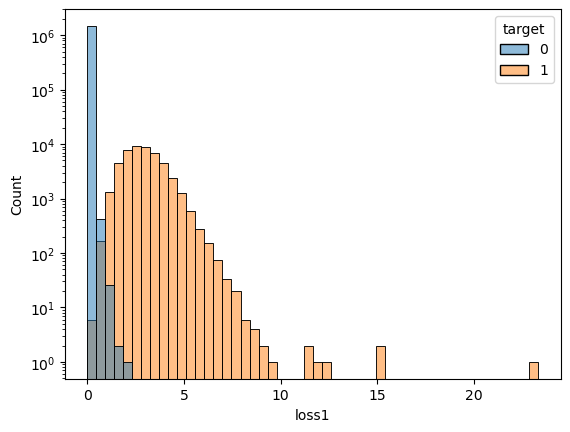

In [18]:
display(oof)
print(oof.query('loss1 != -999 & loss2 != -999')['loss1'].describe())

_, ax = plt.subplots()
sns.histplot(
    data=oof.query('loss1 != -999'),
    x='loss1',
    hue='target',
    bins=50,
    ax=ax
)
plt.yscale('log')
plt.show()

# _, ax = plt.subplots()
# sns.histplot(
#     data=oof.query('loss1 != -999 & loss2 != -999'),
#     x='loss2',
#     hue='target',
#     bins=50,
#     ax=ax
# )
# plt.yscale('log')
# plt.show()

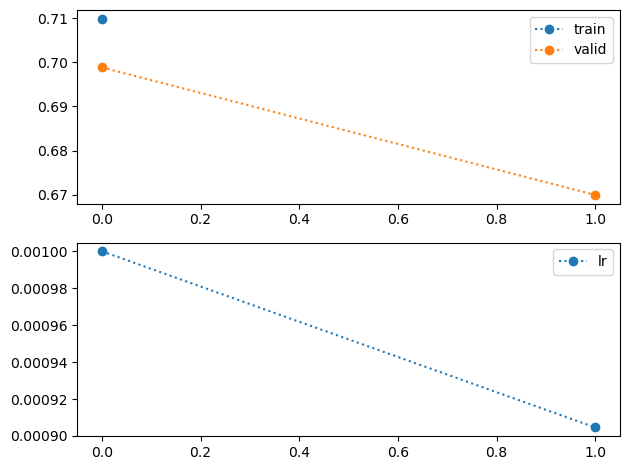

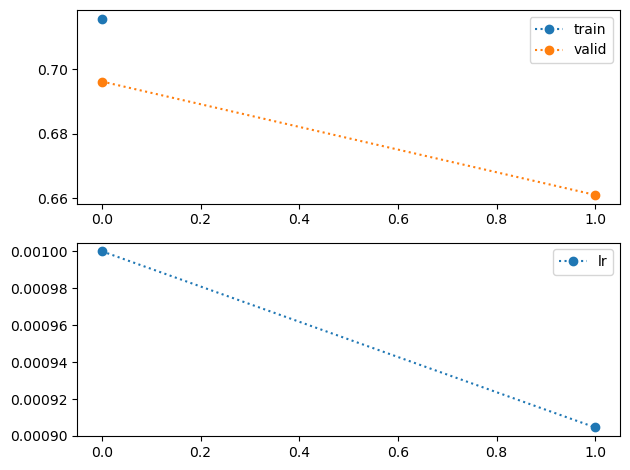

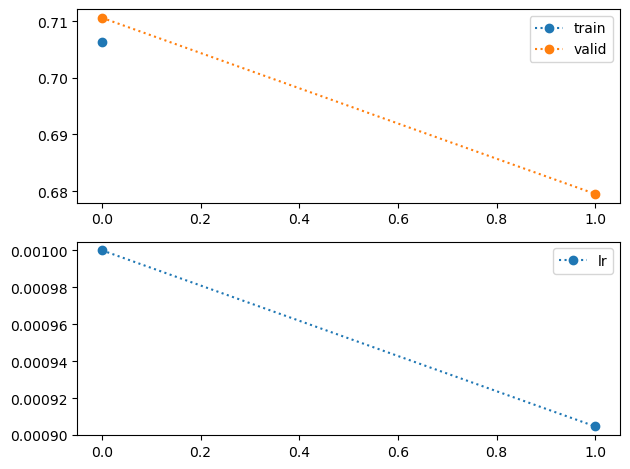

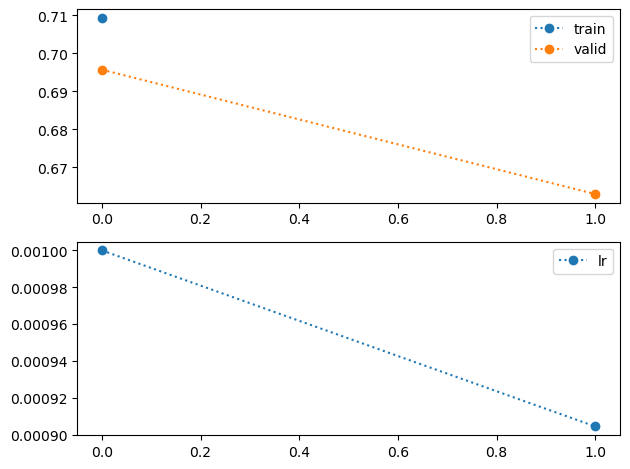

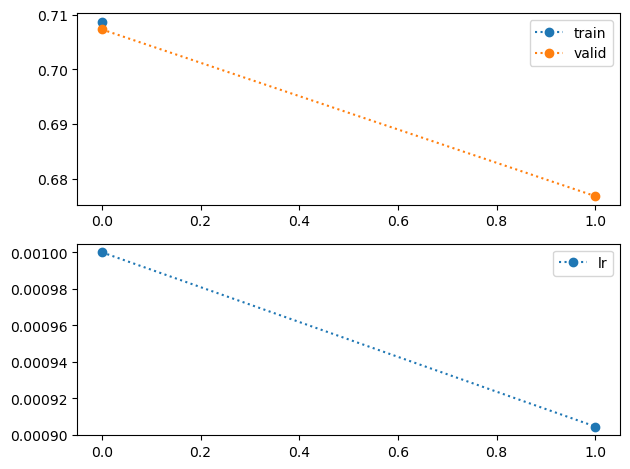

In [19]:
for k in history.keys():
    _, axs = plt.subplots(2, 1)
    history[k]['loss'].plot(marker='o', linestyle=':', ax=axs[0])
    history[k]['lr'].plot(marker='o', linestyle=':', ax=axs[1])
    plt.tight_layout()
    plt.show()

In [20]:
oof.to_csv(paths.output_dir.joinpath('oof.csv'), index=False)

In [21]:
display(mask_truth)
display(mask_preds)

,year_first_birth_259D_1,pmtnum_254L_0,price_1097A_0,mobilephncnt_593L_0,median_dpdmaxdateyear_596T_1,isbidproduct_1095L_0,median_maxdpdtolerance_577P_1,avgdpdtolclosure24_3658938P_0,max_totalamount_6A_1,year_first_empl_employedfrom_271D_1,...,first_registaddr_district_1083M_1,lastapprcommoditycat_1041M_0,lastrejectreasonclient_4145040M_0,previouscontdistrict_112M_0,first_language1_981M_1,disbursementtype_67L_0,first_education_1138M_1,first_district_544M_1,first_rejectreasonclient_4145042M_1,first_contractst_964M_1
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1526655,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1526656,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1526657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


,year_first_birth_259D_1,pmtnum_254L_0,price_1097A_0,mobilephncnt_593L_0,median_dpdmaxdateyear_596T_1,isbidproduct_1095L_0,median_maxdpdtolerance_577P_1,avgdpdtolclosure24_3658938P_0,max_totalamount_6A_1,year_first_empl_employedfrom_271D_1,...,first_registaddr_district_1083M_1,lastapprcommoditycat_1041M_0,lastrejectreasonclient_4145040M_0,previouscontdistrict_112M_0,first_language1_981M_1,disbursementtype_67L_0,first_education_1138M_1,first_district_544M_1,first_rejectreasonclient_4145042M_1,first_contractst_964M_1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
2,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1526655,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1526656,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1526657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [22]:
corr_coef = []
for col in mask_truth.columns:
    corr_coef.append((col, np.corrcoef(mask_truth[col], mask_preds[col])[0, 1]))
corr_coef = pd.DataFrame(corr_coef, columns=['Variable', 'correlation coefficient'])
corr_coef.sort_values('correlation coefficient', inplace=True)
corr_coef.set_index('Variable', inplace=True)
display(corr_coef)

/home/ss/miniconda3/envs/home_credit/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ss/miniconda3/envs/home_credit/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,correlation coefficient
Variable,
sum_numberofoutstandinstls_59L_1,-0.001273
numinstlswithdpd5_4187116L_0,-0.001141
median_annuity_853A_1,-0.000972
day_datelastunpaid_3546854D_0,-0.000962
max_median_pmts_dpd_303P_2,-0.000915
...,...
year_firstclxcampaign_1125D_0,NaN
maxoutstandbalancel12m_4187113A_0,NaN
numinstpaidlate1d_3546852L_0,NaN


<Axes: ylabel='Variable'>

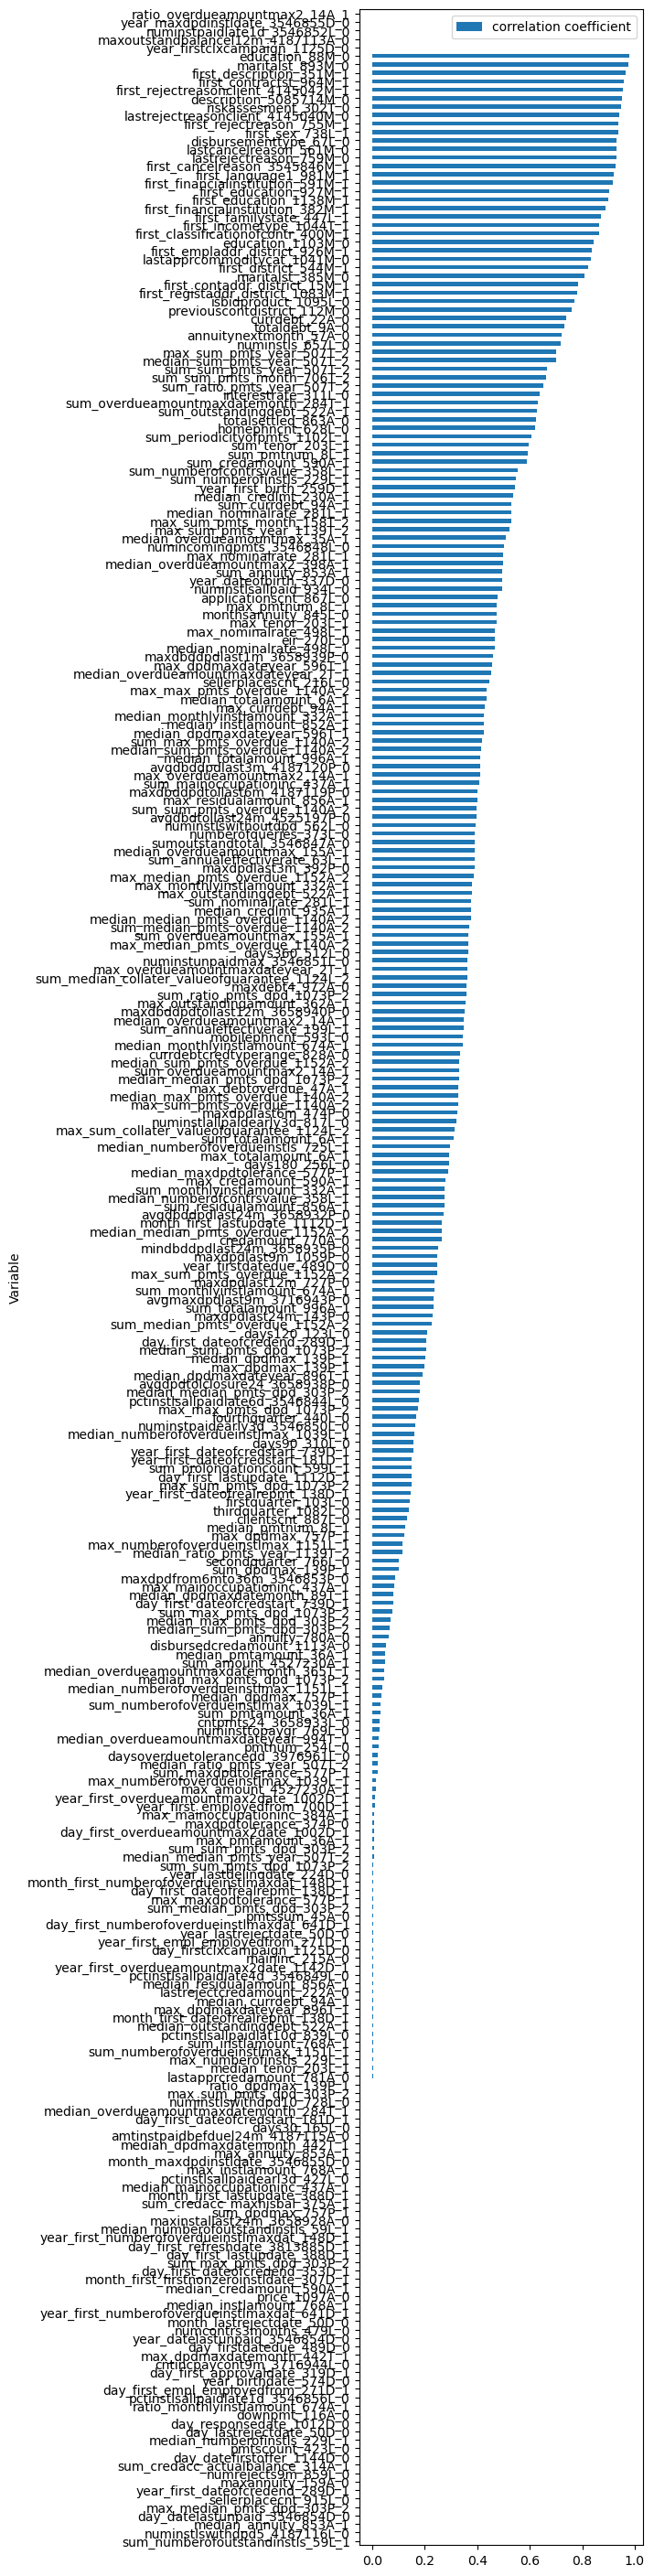

In [23]:
corr_coef.plot.barh(figsize=(4, 36))

,case_id,date_decision,MONTH,WEEK_NUM,target,loss1,loss2,probability,fold
0,0,2019-01-03,201901,0,0,0.034233,0.422724,0.018749,0.0
1,1,2019-01-03,201901,0,0,0.052270,0.472881,0.020893,0.0
2,2,2019-01-04,201901,0,0,0.029502,0.437778,0.032543,0.0
3,3,2019-01-03,201901,0,0,0.055477,0.440917,0.034496,0.0
4,4,2019-01-04,201901,0,1,3.354283,0.452552,0.053628,0.0
...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.000641,0.586784,0.000644,0.0
1526655,2703451,2020-10-05,202010,91,0,0.004265,0.584382,0.002444,0.0
1526656,2703452,2020-10-05,202010,91,0,0.027837,0.609405,0.107268,0.0
1526657,2703453,2020-10-05,202010,91,0,0.003977,0.573609,0.003223,0.0


count    1.526659e+06
mean     3.225015e-02
std      4.025803e-02
min      0.000000e+00
25%      7.265898e-03
50%      1.858921e-02
75%      4.122865e-02
max      9.998699e-01
Name: probability, dtype: float64


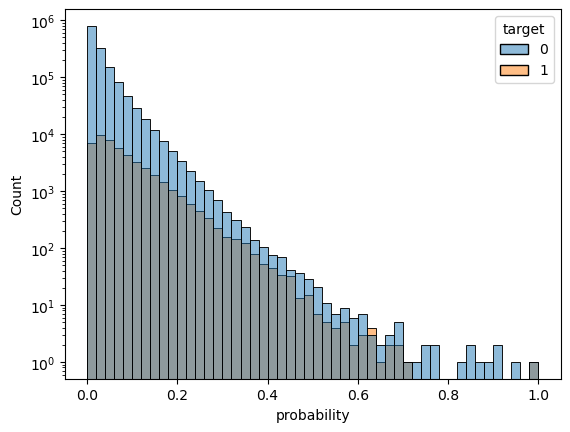

In [24]:
display(oof)
print(oof.query('probability != -1')['probability'].describe())

_, ax = plt.subplots()
sns.histplot(
    data=oof.query('probability != -1'),
    x='probability',
    hue='target',
    bins=50,
    ax=ax
)
plt.yscale('log')
plt.show()

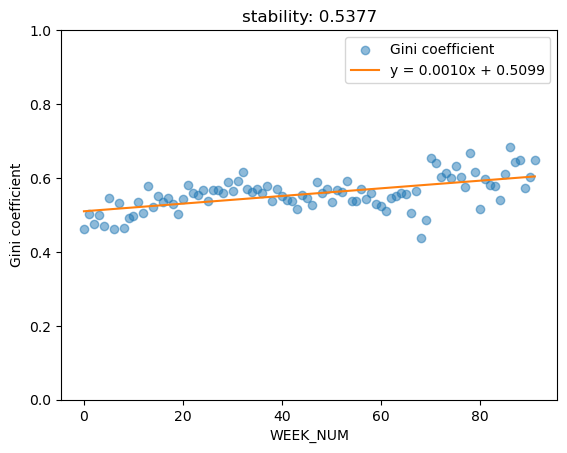

,WEEK_NUM,gini,regression,residuals
0,0,0.462255,0.509867,-0.047613
1,1,0.502304,0.510903,-0.008598
2,2,0.474821,0.511939,-0.037118
3,3,0.498631,0.512974,-0.014343
4,4,0.469439,0.514010,-0.044571
...,...,...,...,...
87,87,0.642919,0.599968,0.042952
88,88,0.648209,0.601003,0.047206
89,89,0.572169,0.602039,-0.029870
90,90,0.602545,0.603075,-0.000530


2024-05-15 22:46:28,910 scripts.get_logger:6 <module> [INFO]:
stability: 0.537707020556411
slope: 0.0010356367715095055
intercept: 0.5098673086606396



   stability     slope  intercept
0   0.537707  0.001036   0.509867


In [25]:
evaluater = Evaluator(oof.query('probability!=-1'))
gini_per_week, outcome = evaluater.plot_gini()
display(gini_per_week)
print(outcome)

logger.info(
    f'stability: {outcome["stability"].item()}\n'
    + f'slope: {outcome["slope"].item()}\n'
    + f'intercept: {outcome["intercept"].item()}\n'
)

outcome.to_csv(paths.output_dir.joinpath('outcome.csv'), index=False)